# Sightline gridding

We demonstrate the gridding of selected sightlines with `cygrid`. This can be particularly useful if you have some high-resolution data such as QSO absorption spectra and want to get accurate foreground values from a dataset with lower angular resolution.

We start by adjusting the notebook settings.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We attempt to limit our dependencies as much as possible, but [`astropy`](https://astropy.readthedocs.org/en/stable/) and [`healpy`](http://healpy.readthedocs.org) needs to be available on your machine if you want to re-run the calculations. We can highly recommend [`anaconda`](https://www.continuum.io/downloads) as a scientific `python` platform.

In [2]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

import healpy as hp
from astropy.io import fits
from astropy.utils.misc import NumpyRNGContext

import cygrid

## Create dummy data

The properties of the map are given by the ordering and the nside of the map. For more details, check the paper by [Gorski et al. (2005)](http://adsabs.harvard.edu/abs/2005ApJ...622..759G).

In [3]:
NSIDE = 128
NPIX = hp.nside2npix(NSIDE)

The `data` are just random draws from the standard normal distribution. For the `weights`, we choose uniform weighting. The coordinates can be easily calculated with `healpy`.

In [4]:
# data and weights
with NumpyRNGContext(0):
    # make sure to have "predictable" random numbers
    input_data = np.random.randn(NPIX)

# coordinates
theta, phi = hp.pix2ang(NSIDE, np.arange(NPIX))
lons = np.rad2deg(phi)
lats = 90. - np.rad2deg(theta)

The pixel size for this NPIX is:

In [5]:
print('pixel size: {:.1f}"'.format(3600 * hp.nside2resol(NSIDE)))

pixel size: 28.8"


A quick look confirms that our `data` looks just as expected. 

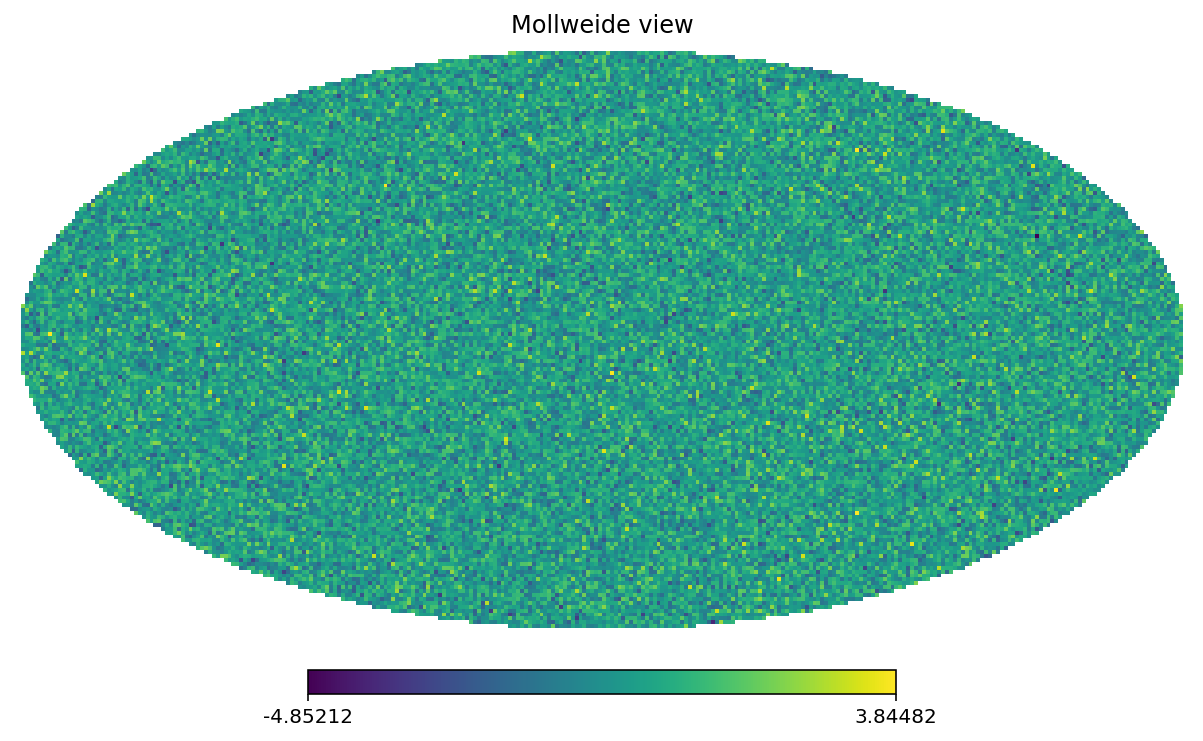

In [6]:
hp.mollview(input_data, xsize=300)

## Gridding

We are now interested in the values of this map at a couple of given positions. It wouldn't make sense to use cygrid at all, if we were just interested in the values of the map at the given positions. Even when the positions are not exactly aligned with the HEALPix pixel centers, employing some interpolation routine would do a good job.

But let's assume that we would want to compare the values with another data set, whose angular resolution is much worse. Then it is reasonable to down-sample (i.e., lower the angular resolution by smoothing with a Gaussian kernel) our HEALPix map before extracting the sight-line values. With `cygrid's` sight-line gridder, this is done only for the vicinity of the requested positions, which can save a lot of computing time (only for large `NSIDE`, because `healpy's` smoothing function is very fast for small and moderate `NSIDE` due to the use of FFTs). `cygrid` would be at true advantage for most other projections, though.

In order to compare the results with `healpy's` smoothing routine (see below), we will use HEALPix pixel center coordinates without loss of generality.

In [7]:
with NumpyRNGContext(0):
    target_hpx_indices = np.random.randint(0, NPIX, 5)

theta, phi = hp.pix2ang(NSIDE,target_hpx_indices)
target_lons = np.rad2deg(phi)
target_lats = 90. - np.rad2deg(theta)

print('{:>8s} {:>8s}'.format('glon', 'glat'))
for glon, glat in zip(target_lons, target_lats):
    print('{:8.4f} {:8.4f}'.format(glon, glat))

    glon     glat
213.0469  33.8687
159.3925 -50.0915
315.3516 -11.4152
141.3636 -53.1873
356.4844 -33.1529


We initiate the gridder by specifying the target sightlines.

In [8]:
gridder = cygrid.SlGrid(target_lons, target_lats)

The gridding kernel is of key importance for the entire gridding process. `cygrid` allows you to specify the shape of the kernel (e.g. elliptical Gaussian or tapered sinc) and its size.

In our example, we use a symmetrical Gaussian (i.e. the major and minor axis of the kernel are identical). In that case, we need to furthermore specify `kernelsize_sigma`, the `sphere_radius` up to which the kernel will be computed, and the maximum acceptable healpix resolution for which we recommend `kernelsize_sigma/2`.

We refer to section 3.5 of the paper ('a minimal example') for a short discussion of the kernel parameters.

In [9]:
kernelsize_fwhm = 1.  # 1 degree
# see https://en.wikipedia.org/wiki/Full_width_at_half_maximum
kernelsize_sigma = kernelsize_fwhm / np.sqrt(8 * np.log(2))
sphere_radius = 4. * kernelsize_sigma

gridder.set_kernel(
    'gauss1d',
    (kernelsize_sigma,),
    sphere_radius,
    kernelsize_sigma / 2.
    )

After the kernel has been set, we perform the actual gridding by calling `grid()` with the coordinates and the data.

In [10]:
gridder.grid(lons, lats, input_data)

To get the gridded data, we simply call `get_datacube()`.

In [11]:
sightlines = gridder.get_datacube()

Finally, we get a list of our gridded sightlines within the chosen aperture.

We can compare this with the `healpy` smoothing operation:

In [12]:
smoothed_map = hp.sphtfunc.smoothing(
    input_data,
    fwhm=np.radians(kernelsize_fwhm),
    )
smoothed_data = smoothed_map[target_hpx_indices]

Sigma is 25.479654 arcmin (0.007412 rad) 
-> fwhm is 60.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [13]:
print('{:>8s} {:>8s} {:>10s} {:>10s}'.format(
    'glon', 'glat', 'cygrid', 'healpy')
     )
for t in zip(
        target_lons, target_lats,
        sightlines, smoothed_data,
        ):
    print('{:8.4f} {:8.4f} {:10.6f} {:10.6f}'.format(*t))

    glon     glat     cygrid     healpy
213.0469  33.8687   0.250371   0.249856
159.3925 -50.0915  -0.253779  -0.241174
315.3516 -11.4152  -0.483739  -0.485754
141.3636 -53.1873  -0.232961  -0.244540
356.4844 -33.1529  -0.072116  -0.072234


Note, that it is expected that the two methods differ somewhat, because they are based on very different techniques (`healpy` transforms the map to harmonic space and convolves the harmonic coefficients $a_{lm}$ with the beam, which is also transformed to harmonic space).